# Week 6 - Classification

This week, we shift from gathering human textual classifications through crowdsourcing, to using machine learning models and algorithms that train on those human classifications and extend them to documents far too numerous to read. If you recall, *clustering* allows us to stably partition text data (e.g., documents, turns of conversation) according to all patterns of covariation among available text features. *Classification*, by contrast, partitions text data according to only those features and their variation that enable us to mimic and extrapolate human annotations.

In this notebook, we will show how to use a variety of classification methods, including Naïve Bayes, Logistic regression, K-nearest neighbor, decision trees and random forests, support vector machines and even a simple neural network, the perceptron. We will also demonstrate ensemble techniques that can link several such methods into a single, more accurate, classification pipeline. We will finally learn to use conventions and metrics to evaluate classifier performance on out-of-sample data. 

For this notebook we will be using the following packages.

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import nltk #For tokenizing and normalizing
import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

# Simple Simulated Examples

Here we create a sandbox for you to explore different types of classified data and how different statistical classifiers perform on each type.

## Generating example data

We start by loading one of the "cartoon" or simplified data sets and then dividing it into training and testing sets. To maximize our ability to visualize, each dataset involves two classes, colored yellow and blue, arrayed along two two dimensions (`x` and `y`). 

The four data patterns include: 
+ `random` in which the two classes are randomly distributed across both dimensions
+ `andSplit` in which the two classes are linearly split along one of two dimensions (e.g., men like Adidas)
+ `xorSplit` in which the two classes are split, oppositely, along each dimension (e.g., old ladies and young men like Nikes)
+ `targetSplit` in which one class is nested within the other in two dimensions (e.g., middle aged, middle income people like vintage Mustangs)
+ `multiBlobs` in which 5 classes are placed as bivariate Gaussians at random locations

`noise` is a variable [0-1] that ranges from no noise in the prescribed pattern [0] to complete noise/randomness [1].

Uncomment (remove the # in front of) each dataset, one at a time, and then run the cell and subsequent cells to examine how each machine learning approach captures each pattern.

In [19]:
lownoise = .2
mednoise = .4
highnoise = .8

rdfTrain, rdfTest = lucem_illud.trainTestSplit(lucem_illud.random())

lnadfTrain, lnadfTest = lucem_illud.trainTestSplit(lucem_illud.andSplit(lownoise))
lnxdfTrain, lnxdfTest = lucem_illud.trainTestSplit(lucem_illud.xorSplit(lownoise)) #Please try this one
lntdfTrain, lntdfTest = lucem_illud.trainTestSplit(lucem_illud.targetSplit(lownoise))
lnmdfTrain, lnmdfTest = lucem_illud.trainTestSplit(lucem_illud.multiBlobs(lownoise))

mnxdfTrain, mnxdfTest = lucem_illud.trainTestSplit(lucem_illud.xorSplit(mednoise))

hnadfTrain, hnadfTest = lucem_illud.trainTestSplit(lucem_illud.andSplit(highnoise))
hnxdfTrain, hnxdfTest = lucem_illud.trainTestSplit(lucem_illud.xorSplit(highnoise))
hntdfTrain, hntdfTest = lucem_illud.trainTestSplit(lucem_illud.targetSplit(highnoise))
hnmdfTrain, hnmdfTest = lucem_illud.trainTestSplit(lucem_illud.multiBlobs(highnoise))

We can easily visualize the rendered datasets because they are generated in two dimensions.

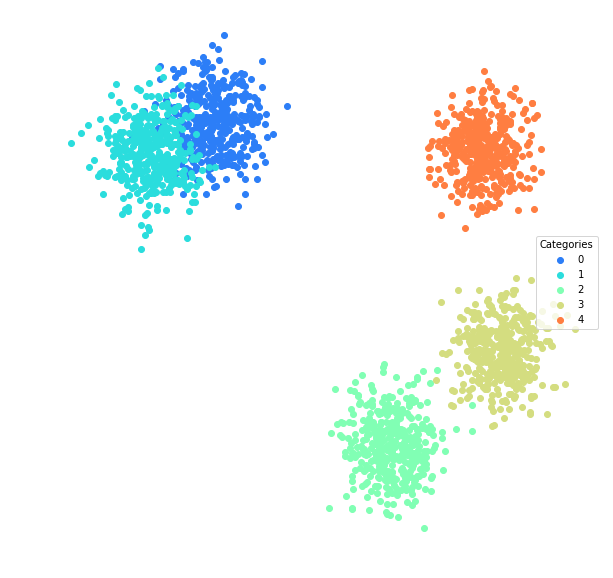

In [206]:
lucem_illud.plotter(lnmdfTrain)

## Training a Machine Learning algorithm

We can now pick a model, there are many more options in `scikit-learn`. These are just a few examples, which array along the machine learning "tribes" described in Pedro Domingos _The Master Algorithm_.

Uncomment (remove the # in front of) each algorithm one at a time, then run the cell and subsequent cells to evaluate how it learns to understand the data.

In [246]:
#Bayes
lnclf = sklearn.naive_bayes.GaussianNB()
hnclf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#lnclf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up
#hnclf = sklearn.svm.SVC(kernel = 'linear', probability = True) #slow, set probability = False to speed up


#lnclf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower
#hnclf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = True) #slower

#lnclf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'
#hnclf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#lnclf = sklearn.linear_model.LogisticRegression()
#hnclf = sklearn.linear_model.LogisticRegression()

#Symbolists
#lnclf = sklearn.tree.DecisionTreeClassifier()
#hnclf = sklearn.tree.DecisionTreeClassifier()

#lnclf = sklearn.ensemble.RandomForestClassifier()
#hnclf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#lnclf = sklearn.neural_network.MLPClassifier()
#hnclf = sklearn.neural_network.MLPClassifier()

#Ensemble
#lnclf = sklearn.ensemble.GradientBoostingClassifier()
#hnclf = sklearn.ensemble.GradientBoostingClassifier()

Now we fit the model by giving it our training data

In [247]:
lnclf.fit(np.stack(lnmdfTrain['vect'], axis=0), lnmdfTrain['category'])
hnclf.fit(np.stack(hnmdfTrain['vect'], axis=0), hnmdfTrain['category'])

GaussianNB(priors=None)

## Algorithm evaluation

We can look at few measurements of each classifier's performance by using the testing set

In [248]:
lucem_illud.evaluateClassifier(lnclf, lnmdfTest)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.966874,0.919966,0.02,0.961905,0.943925
1,0.973518,0.916805,0.02,0.944444,0.962264
2,1.000000,1.000000,0.00,1.000000,1.000000
3,1.000000,1.000000,0.00,1.000000,1.000000
4,1.000000,1.000000,0.00,1.000000,1.000000


In [249]:
lucem_illud.evaluateClassifier(hnclf, hnmdfTest)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.903438,0.752445,0.062,0.852941,0.844660
1,0.869577,0.677962,0.086,0.800000,0.792453
2,0.949702,0.840659,0.034,0.894737,0.923913
3,0.931163,0.808471,0.048,0.878505,0.895238
4,0.905434,0.759600,0.054,0.868132,0.840426


This lets us look at which classes do better:

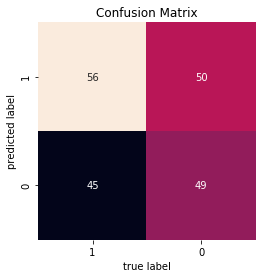

In [82]:
lucem_illud.plotConfusionMatrix(clf, rdfTest)

The greater the area under the curve the better.

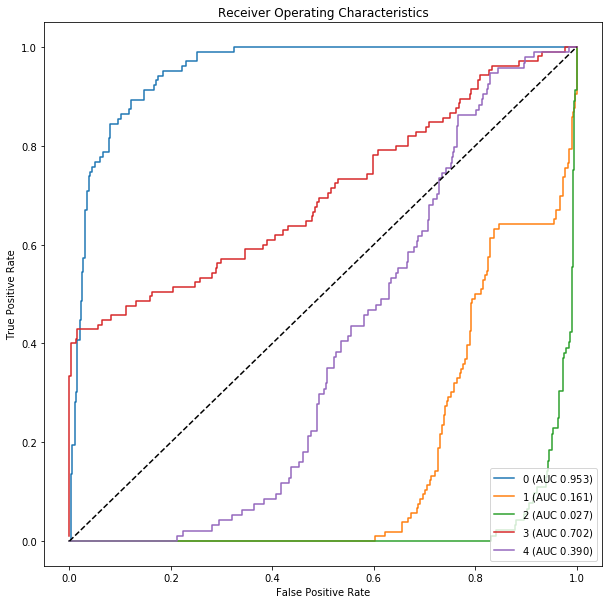

In [214]:
lucem_illud.plotMultiROC(lnclf, hnmdfTest)

We can also look at the regions the classifer identifies as one class or the other:

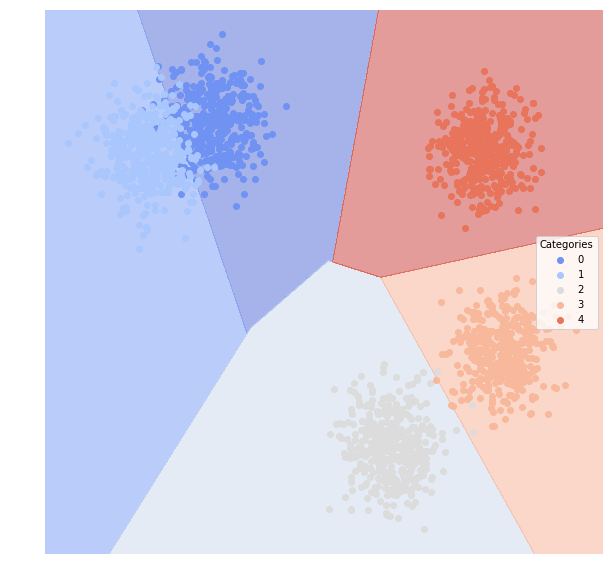

In [215]:
lucem_illud.plotregions(lnclf, lnmdfTrain)

## Now we do the same for real data

Available data sets include:
+ Reddit threads "classified" by thread topic
+ 20 newsgroups "classified" by group topic
+ Senate press releases "classified" by Senator (2 senators)
+ Senate press releases "classified" by Senator (5 senators)
+ Emails classified as Spam or Ham

In [101]:
rdfTrain, rdfTest = lucem_illud.trainTestSplit(lucem_illud.loadReddit())
ndfTrain, ndfTest = lucem_illud.trainTestSplit(lucem_illud.loadNewsGroups())
ssdfTrain, ssdfTest = lucem_illud.trainTestSplit(lucem_illud.loadSenateSmall())
sldfTrain, sldfTest = lucem_illud.trainTestSplit(lucem_illud.loadSenateLarge())
sdfTrain, sdfTest = lucem_illud.trainTestSplit(lucem_illud.loadSpam())

Loading Reddit data
Converting to vectors


KeyboardInterrupt: 

In [416]:
#Bayes
#clf = sklearn.naive_bayes.GaussianNB()

#Analogizes
#clf = sklearn.svm.SVC(kernel = 'linear', probability = False) #slow, set probability = False to speed up, but lose ROC
#clf = sklearn.svm.SVC(kernel = 'poly', degree = 3, probability = False) #slower
#clf = sklearn.neighbors.KNeighborsClassifier(5, weights='distance')# k, 'distance' or 'uniform'

#Classical Regression
#clf = sklearn.linear_model.LogisticRegression()

#Symbolists
#clf = sklearn.tree.DecisionTreeClassifier()
#clf = sklearn.ensemble.RandomForestClassifier()

#Connectionists
#clf = sklearn.neural_network.MLPClassifier()

#Ensemble
clf = sklearn.ensemble.GradientBoostingClassifier()

In [417]:
clf.fit(np.stack(sdfTrain['vect'], axis=0), sdfTrain['category'])

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [418]:
lucem_illud.evaluateClassifier(clf, sdfTest)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
spam,0.669203,0.396027,0.100877,0.871795,0.346939
not spam,0.669203,0.900399,0.100877,0.900775,0.991468


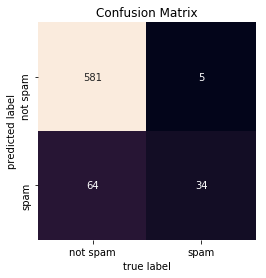

In [419]:
lucem_illud.plotConfusionMatrix(clf, sdfTest)

In [397]:
lucem_illud.plotMultiROC(clf, sdfTest)

The <class 'sklearn.svm.classes.SVC'> classifier does not apear to support prediction probabilties, so an ROC curve can't be created. You can try adding `probability = True` to the model specification or use a different model.


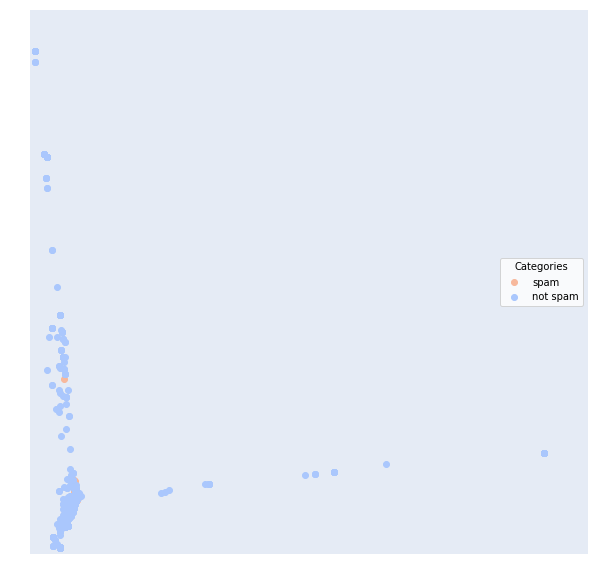

In [392]:
lucem_illud.plotregions(clf, sdfTrain)

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Go back through all of the cells above and generate 10 distinct artificial datasets and classify them with all of the available methods. Add a cell immediately below and describe which classifier(s) worked best with which artificially constructed data source and why. Then go through all of the empirical datasets (i.e., Newsgroups, Senate Small, Senate Large, Email Spam) and classify them with all available methods. Add a second cell immediately below and describe which classifier(s) worked best with which data set and why.

<span style="color:red">***Stretch*** (but also required) Wander through the SKLearn documentation available [here](http://scikit-learn.org/stable/), particularly perusing the classifiers. In cells following, identify and implement a new classifier that we have not yet used (e.g., AdaBoost, CART) on one artificial dataset and one real dataset (used above). Then, in the next cell describe the classifier, detail how it compares with the approaches above, and why it performed better or worse than others.

For a `random` dataset: Bayesian classification is not good (~ floor), Linear SVM is floor, Polynomial SVM is floor, K Neighbors is floor, Logistic Regression is floor, Decision Tree is floor, Random Forests is near floor, MLP is floor, and Gradient Boost is floor (perhaps all to be expected.)

For `andsplit` dataset: Bayesian classification is good (~88% ln, ~65% hn), Linear SVM is OK (~80% ln, ~60% hn), Polynomial SVM is a bit better (in low noise case) [~86% ln, ~55% hn], K Neighbors is OK (~85% ln, 55% hn), Logistic Regression (87% ln, 60 hn), DT (82% ln, 53% hn), RF(83% ln, 57% hn), MLP (87% ln, 60% hn), GB (81% ln, 60% hn).

For `xor` dataset: Symbolists are the best – RF (~87% ln, 65% hn)

For `targetSplit` dataset: Bayes & Ensemble models are best (~90% ln, 65% hn); Symbolists are quite good as well (~88% ln, ~55% hn)

For `multiBlobs` dataset: All are decently good (avg. ~85%+ ln, 80% hn); Bayes is best with low noise (~90%).


For `reddit` dataset: Linear SVC has ~99% accuracy; Logistic regression / MLP / Gradient Boost looks similar.

For `NewsGroups` dataset: Bayes, Logistic Regression, MLP, Gradient Boosting all around 77-85% accuracy

For `Senate` small dataset: Linear SVC, Logistic Regression, Decision Tree, Random Forest, are all quite good (90%+). Gradient Boosting results in perfect performance on the test set.

For `Senate` large dataset: Linear SVC, Logistic Regression, Decision Tree, MLP are all quite good (90%+)

For `Spam` dataset: Most methods did about the same (~90%+ for not spam, ~50% for spam); all tended to err on the side of false negatives (i.e., identifying spam as non spam).

In [422]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=100)

In [423]:
clf.fit(np.stack(lntdfTrain['vect'], axis=0), lntdfTrain['category'])

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)

In [424]:
lucem_illud.evaluateClassifier(clf, lntdfTest)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.894258,0.846747,0.105,0.871560,0.931373
1,0.894258,0.861209,0.105,0.923077,0.857143


For the `target` dataset, AdaBoost does about as well as other models in the Symbolist camp

In [425]:
clf.fit(np.stack(ndfTrain['vect'], axis=0), ndfTrain['category'])

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)

In [426]:
lucem_illud.evaluateClassifier(clf, ndfTest)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
comp.windows.x,0.863724,0.725317,0.082979,0.877551,0.761062
comp.sys.mac.hardware,0.780952,0.570185,0.146809,0.752475,0.633333
misc.forsale,0.803906,0.609919,0.144681,0.760684,0.689922
rec.autos,0.816247,0.508162,0.182979,0.571429,0.814815


For the `newsgroups` dataset, AdaBoost doesn't fare as well as the top picks, perhaps due to the overlapping clusters that make up the data.

# Clinton / Obama Press Releases

We often will not have nicely prepared data, so we will work though the proccess of cleaning and structuring in more detail here:

While the Clinton and Obama Senatorial Press Releases are not hand-coded, we can imagine that we have been given a stack of such press releases, but lost the metadata associated with which senatorial office issued which. If we label a few of them, how well can our classifier do at recovering the rest? 

In [427]:
ObamaClintonReleases = pandas.read_csv('../data/ObamaClintonReleases.csv', index_col=0)

Let's turn the 'targetSenator' column into a binary category variable.

In [428]:
ObamaClintonReleases['category'] = [s == 'Obama' for s in ObamaClintonReleases['targetSenator']]

Tokenize and normalize

In [429]:
ObamaClintonReleases['tokenized_text'] = ObamaClintonReleases['text'].apply(lambda x: nltk.word_tokenize(x))
ObamaClintonReleases['normalized_text'] = ObamaClintonReleases['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

Let's split the data into training data and testing data.

In [430]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud.trainTestSplit(ObamaClintonReleases, holdBackFraction=holdBackFraction)

In [431]:
print(len(train_data_df))
print(len(test_data_df))

1368
341


## Logistic Regression

First, let's try with a logistic regression, which may be familiar to you from statistical methods classes. First, we must turn the training dataset into a tf-idf matrix (`lucem_illud.generateVecs()` will help with this but for now we are doing it the long way):

In [432]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['text'])

Note that we can use the CountVectorizer instead, which simply produces a matrix of word counts.

In [433]:
TFVects.shape

(1368, 11165)

We can save this in the dataframe to make things easier

In [434]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]

In a regression, we cannot have more variables than cases. So, we need to first do a dimension reduction. First, we will approah this with PCA. You have previously seen this in week 3. Here we are not concerned about visualization, but rather classification and so all principal components are calculated. Watch out: we have to use `stack` not `sum` for combining the vectors. We note that you could also use topic loading and embedding dimensions as featured variables.

In [435]:
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))

We can store the PCA space vectors in the dataframe too:

In [436]:
train_data_df['pca'] = [r for r in reduced_data]

Visualization in 2D:

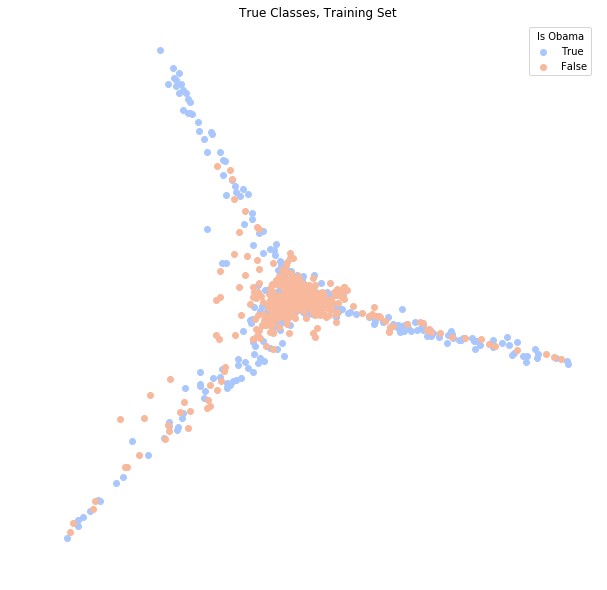

In [437]:
fig, ax = plt.subplots(figsize = (10,10))
ax.axis('off')
pallet = seaborn.color_palette(palette='coolwarm', n_colors = 2)

#Plot Obama
a = np.stack(train_data_df[train_data_df['category']]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[0], label = "True")

#Plot not Obama
a = np.stack(train_data_df[train_data_df['category'].eq(False)]['pca'])
ax.scatter(a[:,0], a[:, 1], c = pallet[1], label = "False")
    
ax.legend(loc = 'upper right', title = 'Is Obama')
plt.title('True Classes, Training Set')
plt.show()

PCA cannot distinguish Obama very well. Let's perform a screeplot to see how many Principal Components we need.

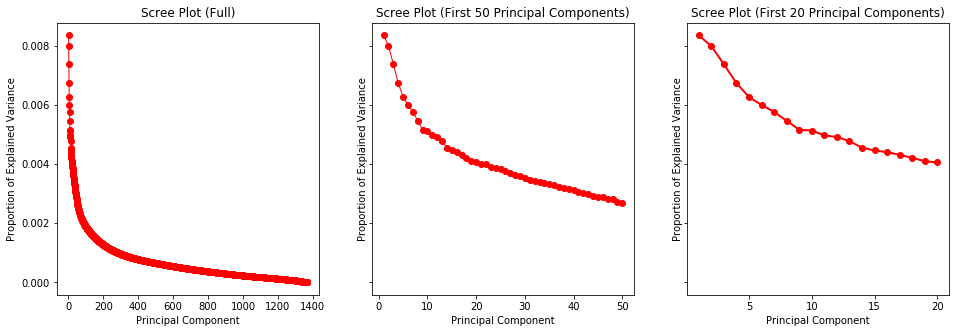

In [439]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 20 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

Let's choose the first 10 pricipal components as our covariates.

In [440]:
train_data_df['pca_reduced_10'] = train_data_df['pca'].apply(lambda x: x[:10])

Now we fit a logistic regression to our data.

In [441]:
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Let's see how the logistic regression performs on the training dataset from which we develop the model. Unfortunately, the mean accuracy is only about 64%.

In [442]:
logistic.score(np.stack(train_data_df['pca_reduced_10'], axis=0), train_data_df['category'])

0.6761695906432749

How does it perform on the testing dataset, which we "held out" and did not use for model training? We need to repeat all the steps on the testing data, but without retraining:

In [443]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['text'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_10'] = test_data_df['pca'].apply(lambda x: x[:10])

#Test
logistic.score(np.stack(test_data_df['pca_reduced_10'], axis=0), test_data_df['category'])

0.7008797653958945

Slightly poorer. How about using more dimensions (40)?

In [444]:
train_data_df['pca_reduced_40'] = train_data_df['pca'].apply(lambda x: x[:40])
test_data_df['pca_reduced_40'] = test_data_df['pca'].apply(lambda x: x[:40])

logistic.fit(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_40'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_40'], axis=0), test_data_df['category']))

Training:
0.7412280701754386
Testing:
0.7272727272727273


Or still more (100)?

In [445]:
train_data_df['pca_reduced_100'] = train_data_df['pca'].apply(lambda x: x[:100])
test_data_df['pca_reduced_100'] = test_data_df['pca'].apply(lambda x: x[:100])

logistic.fit(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_100'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_100'], axis=0), test_data_df['category']))

Training:
0.8245614035087719
Testing:
0.7917888563049853


Or even more (200)!

In [446]:
train_data_df['pca_reduced_200'] = train_data_df['pca'].apply(lambda x: x[:200])
test_data_df['pca_reduced_200'] = test_data_df['pca'].apply(lambda x: x[:200])

logistic.fit(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_200'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_200'], axis=0), test_data_df['category']))

Training:
0.8720760233918129
Testing:
0.8240469208211144


This is becoming ridiculous (400)!

In [447]:
train_data_df['pca_reduced_400'] = train_data_df['pca'].apply(lambda x: x[:400])
test_data_df['pca_reduced_400'] = test_data_df['pca'].apply(lambda x: x[:400])

logistic.fit(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category'])

print("Training:")
print(logistic.score(np.stack(train_data_df['pca_reduced_400'], axis=0), train_data_df['category']))
print("Testing:")
print(logistic.score(np.stack(test_data_df['pca_reduced_400'], axis=0), test_data_df['category']))

Training:
0.9093567251461988
Testing:
0.8269794721407625


Increasing the number of covariates would overfit our data, and it seems that using a logistic regression, our prediction accuracy is at best about 65%. We can, however, try a logistic regression that uses the TF-IDF scores for each word, but with an L1 regularization or L1-norm loss function, which is also known as least absolute deviations (LAD), least absolute errors (LAE) or L1 penalty. It minimizes the sum of the absolute differences (S) between the target value ($Y_i$) and the estimated values ($f(x_i)$) and prunes all insignificant variables (i.e., word TF-IDF scores):

$S=\sum^n_{i=1}|y_i=f(x_i)|$

The result is a model retaining only the most individually significant features.

In [448]:
logistic_l1= sklearn.linear_model.LogisticRegression(penalty='l1')
logistic_l1.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
print(logistic_l1.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))

0.8092105263157895


Train the model using training data, and then test it on the testing data.

In [449]:
print(logistic_l1.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

0.7976539589442815


81% accuracy seems like the best we can get by using a logistic regression.

Now let's try with Naive Bayes. Classically, it is trained with word counts, but TF-IDF vectors are also quite good:

In [450]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [451]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9641812865497076
Testing:
0.9032258064516129


A bit better than the logit, but that's just looking at the accuracy. What about other measures? Let's first save the predictions in the dataframe to save use rerunning the model every time:

In [452]:
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

Precision:

In [453]:
sklearn.metrics.precision_score(test_data_df['nb_predict'], test_data_df['category'])

0.8503937007874016

Recall:

In [454]:
sklearn.metrics.recall_score(test_data_df['nb_predict'], test_data_df['category'])

0.8852459016393442

F1-measure:

In [455]:
sklearn.metrics.f1_score(test_data_df['nb_predict'], test_data_df['category'])

0.8674698795180724

Let's take a look at how well our posterior distribution looks relative to the truth.

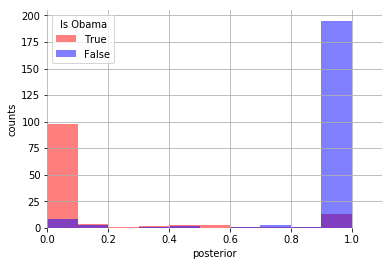

In [456]:
fig, ax = plt.subplots()
ax.grid(False)
ax.set_frame_on(False)
test_data_df[test_data_df['category'].eq(True)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'True', color = 'red')
test_data_df[test_data_df['category'].eq(False)]['nb_predict_prob_true'].hist(alpha = 0.5, ax = ax, bins = 10, label = 'False', color = 'blue')
ax.set_xlim((0,1.1))
ax.legend(title = "Is Obama")
ax.set_xlabel('posterior')
ax.set_ylabel('counts')
plt.show()

The classification is suprisingly accurate. We can even look at what words are most influential with a bit of simple math:

In [457]:
#Top indices
trueVals, falseVals = naiveBayes.feature_log_prob_

words_dict = {
    'Obama' : [],
    'Obama_log_prob' : [],
    'Clinton' : [],
    'Clinton_log_prob' : [],
}

for i, prob in sorted(enumerate(trueVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Obama'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Obama_log_prob'].append(prob)

for i, prob in sorted(enumerate(falseVals), key = lambda x:x[1], reverse=True)[:15]:
    words_dict['Clinton'].append(TFVectorizer.get_feature_names()[i])
    words_dict['Clinton_log_prob'].append(prob)
    
pandas.DataFrame(words_dict)

,Clinton,Clinton_log_prob,Obama,Obama_log_prob
0,amy,-1.826606,signature,-2.226847
1,dick,-1.892564,island,-2.287471
2,brundage,-1.903993,welcomed,-2.300050
3,chicago,-2.026096,fy,-2.312789
4,reform,-2.165208,urging,-2.325693
5,temporary,-2.211018,air,-2.338765
6,location,-2.242767,awarded,-2.338765
7,cases,-2.275556,honor,-2.365433
8,free,-2.309458,point,-2.392832
9,political,-2.309458,urban,-2.406818


## Multinomial Naive Bayes

What if we want to classify our text into one of *many* classes? The multinomial Naive Bayes generating model assumes that document features (e.g., words) are generated by draws from a multinomial distribution (recall this gives the probability to observe a particular pattern of counts across features). 

Let's use again the dataset we used in week 3, the 20 newsgroup dataset.

In [102]:
newsgroups = sklearn.datasets.fetch_20newsgroups(data_home = '../data') #Free data to play with: documents from a newsgroup corpus.
newsgroups.target_names #Possible categories, i.e., the newsgroups

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

We can pick specific categories, and pull the relevant training and testing sets. 

In [103]:
target_categories = ['talk.religion.misc', 'soc.religion.christian', 'sci.space', 'comp.graphics'] #Can change these of course

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])
for category in target_categories:
    print("Loading data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

Loading data for: talk.religion.misc
Loading data for: soc.religion.christian
Loading data for: sci.space
Loading data for: comp.graphics


Now we need to tokenize, and make a training and testing set:

In [104]:
newsgroupsDF['tokenized_text'] = newsgroupsDF['text'].apply(lambda x: nltk.word_tokenize(x))
newsgroupsDF['normalized_text'] = newsgroupsDF['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

In [105]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

In [462]:
print(len(train_ng_df))
print(len(test_ng_df))

1723
430


We need to extract features from the text. We can use built-in feature extraction to do so. We will use a tf-idf vectorizer, which converts the document into a vector of words with tf-idf weights (term-frequency inverse-document frequency). This gives high weight to words that show up a lot in a given document, but rarely across documents in the corpus (more distinctive). 

In [106]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

Now we can train the model:

In [464]:
MultinomialNB_ng = sklearn.naive_bayes.MultinomialNB()
MultinomialNB_ng.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

...and save predictions to the dataframe:

In [465]:
train_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(train_ng_df['vect'], axis=0))
print("Training score:")
print(MultinomialNB_ng.score(np.stack(train_ng_df['vect'], axis=0), train_ng_df['category']))

Training score:
0.8903076030179918


In [466]:
train_ng_df[['category', 'nb_predict']][:10]

,category,nb_predict
843,soc.religion.christian,soc.religion.christian
374,talk.religion.misc,talk.religion.misc
1530,sci.space,sci.space
1212,sci.space,sci.space
311,talk.religion.misc,soc.religion.christian
469,soc.religion.christian,soc.religion.christian
1922,comp.graphics,comp.graphics
860,soc.religion.christian,soc.religion.christian
224,talk.religion.misc,talk.religion.misc
389,soc.religion.christian,soc.religion.christian


Looks pretty good, lets examine the testing dataset:

In [467]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = MultinomialNB_ng.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(MultinomialNB_ng.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.7883720930232558


We can even use a confusion matrix, like we used last week for evaluating human coders relative to one another. Now we are evaluating our classifier relative to human coding. We'll just use the one in `lucem_illud`, which requres a classifier and a dataframe with `'vect'` and `'category'` columns, like we have in the examples:

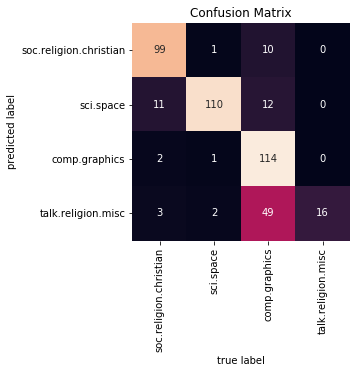

In [468]:
lucem_illud.plotConfusionMatrix(MultinomialNB_ng, test_ng_df)

Let's calculate the precision, recall, and F-measures.

In [469]:
print(sklearn.metrics.precision_score(test_ng_df['nb_predict'], test_ng_df['category'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_ng_df['nb_predict'], test_ng_df['category'], average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test_ng_df['nb_predict'], test_ng_df['category'], average = 'weighted')) #F-1 measure

0.887672714882017
0.7883720930232558
0.8101414513552093


We can evaluate these per catagory. This has the same requiments as `plotConfusionMatrix`:

In [470]:
lucem_illud.metrics.evaluateClassifier(MultinomialNB_ng, test_ng_df)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
talk.religion.misc,0.614286,0.354153,0.125581,1.000000,0.228571
soc.religion.christian,0.873761,0.607393,0.172093,0.616216,0.974359
comp.graphics,0.925000,0.800364,0.062791,0.860870,0.900000
sci.space,0.906800,0.851536,0.062791,0.964912,0.827068


We can also plot the ROC curves. This has the same requiments as `plotConfusionMatrix`:

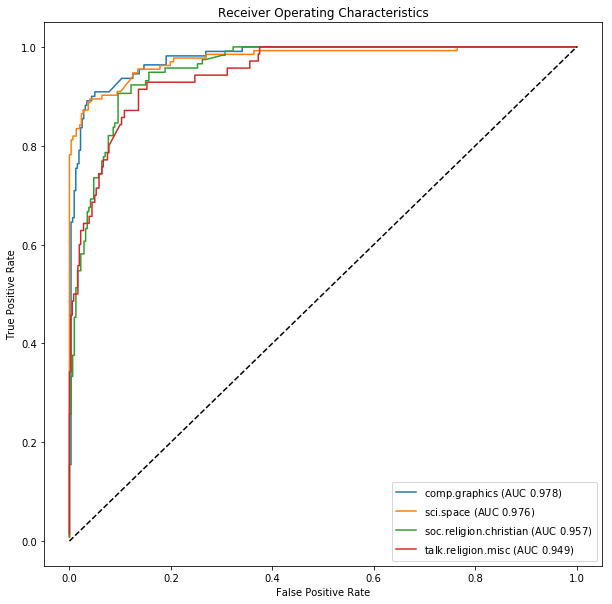

In [471]:
lucem_illud.plotMultiROC(MultinomialNB_ng, test_ng_df)

And we can plot the PCA space visualization:

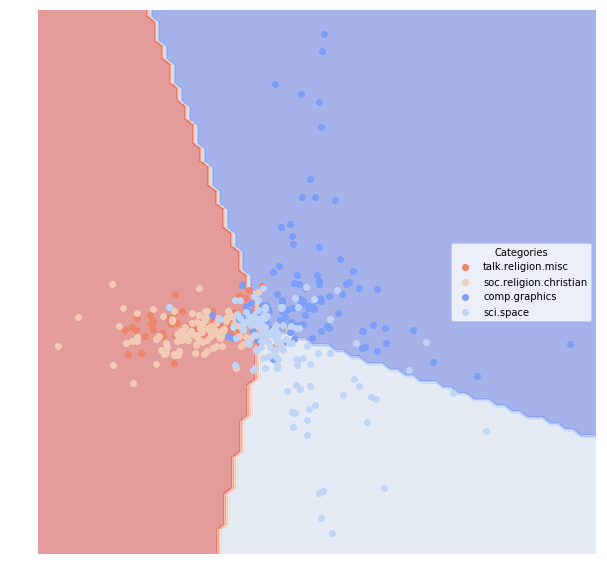

In [472]:
lucem_illud.plotregions(MultinomialNB_ng, test_ng_df)

We can also give the model a new string, not present in our data, and use the *predict* method to see if it can assign it to a category. Using our model to extend its classifications to new, uncoded data might be the primary purpose of a social science application. The words do have to be in the vocabulary, so don't be too creative :-)

In [46]:
def predict_category(s, model, tfidf): #We just define a simple function here
    a = np.zeros((1, len(tfidf.vocabulary_)))
    for w in nltk.word_tokenize(s):
        try:
            a[:,tfidf.vocabulary_[lucem_illud.stemmer_basic.stem(w.lower())]] = 1
        except KeyError:
            print("Warning: '{}' not in vocabulary".format(w))
    return model.predict(a)[0]

In [475]:
predict_category('rockets cool', MultinomialNB_ng, TFVectorizer_ng)

'sci.space'

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">In the cells immediately following, perform Logistic and Naïve Bayes classification (binary or multinomial) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project (e.g., these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week). Visualize the confusion matrix for training and testing sets. Calculate precision, recall, the F-measure, and AUC, then perform an ROC visualization. How do these classifiers perform? Exrapolate codes from these models to all uncoded data.


In [2]:
def wordsample100(tokens):
    '''
    takes a list of tokens and returns a random 100 word sample
    
    Inputs:
        tokens - list of tokenized text
    
    Outputs:
        sample - contiguous 100 word sample from tokens
    '''
    
    if len(tokens) <= 100:
        sample = tokens
    else:
        startindex = random.randint(1, len(tokens)-100)
        sample = tokens[startindex : startindex+100]
    
    return sample

In [3]:
ldpdf = pandas.read_csv('../ChildBookProject/ldpdf.csv', index_col=0)
bookdf = pandas.read_csv('../ChildBookProject/bookdf.csv', index_col=0)

In [57]:
ldpdf['chat_tokens'] = ldpdf.p_chat.apply(lambda x: nltk.wordpunct_tokenize(x))
ldpdf['word_count'] = ldpdf.chat_tokens.apply(lambda x: len(x))
ldpdf['wordsample100'] = ldpdf.chat_tokens.apply(lambda x: wordsample100(x))
ldpdf['category'] = False

In [58]:
bookdf['tokens'] = bookdf['text'].apply(lambda x: nltk.wordpunct_tokenize(x))
bookdf['nltktext'] = bookdf['tokens'].apply(lambda x: nltk.Text(x))
bookdf['word_count'] = bookdf.tokens.apply(lambda x: len(x))
bookdf['wordsample100'] = bookdf.tokens.apply(lambda x: wordsample100(x))
bookdf['category'] = True

In [59]:
compdf = pandas.DataFrame({'wordsample100': pandas.concat([bookdf['wordsample100'], ldpdf['wordsample100']]), 'category' : pandas.concat([bookdf['category'], ldpdf['category']])})
compdf = compdf.reset_index(drop = True)

In [60]:
compdf['wordsampletext'] = compdf.wordsample100.apply(lambda x: ' '.join(x))

In [61]:
compdf.head()

,category,wordsample100,wordsampletext
0,True,"[:, "", Meow, ."", "", No, ,, George, ,"", said, G...",": "" Meow ."" "" No , George ,"" said George ’ s m..."
1,True,"[Sal, hurried, ahead, and, dropped, a, blueber...",Sal hurried ahead and dropped a blueberry in h...
2,True,"[you, see, ?, I, see, a, blue, horse, looking,...",you see ? I see a blue horse looking at me . B...
3,True,"[Click, ,, clack, ,, moo, ., Click, ,, clack, ...","Click , clack , moo . Click , clack , moo . Th..."
4,True,"[themselves, in, the, new, land, ., The, bigge...",themselves in the new land . The biggest chang...


In [62]:
holdBackFraction = .2
train_data_df, test_data_df = lucem_illud.trainTestSplit(compdf, holdBackFraction=holdBackFraction)

In [63]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects = TFVectorizer.fit_transform(train_data_df['wordsampletext'])

In [64]:
train_data_df['vect'] = [np.array(v).flatten() for v in TFVects.todense()]
pca = sklearn.decomposition.PCA()
reduced_data = pca.fit_transform(np.stack(train_data_df['vect'], axis=0))
train_data_df['pca'] = [r for r in reduced_data]

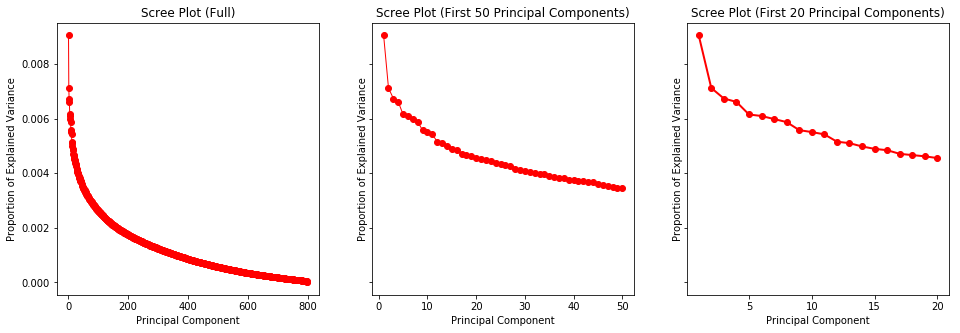

In [65]:
n = len(train_data_df)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (16, 5), sharey=True)

eigen_vals = np.arange(n) + 1
ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=1)
ax1.set_title('Scree Plot (Full)')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

eigen_vals = np.arange(50) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:50], 'ro-', linewidth=1)
ax2.set_title('Scree Plot (First 50 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')


eigen_vals = np.arange(20) + 1
ax3.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax3.set_title('Scree Plot (First 20 Principal Components)')
ax3.set_xlabel('Principal Component')
ax3.set_ylabel('Proportion of Explained Variance')

plt.show()

I'll first try using the first 20 components.

In [67]:
train_data_df['pca_reduced_20'] = train_data_df['pca'].apply(lambda x: x[:20])
logistic = sklearn.linear_model.LogisticRegression()
logistic.fit(np.stack(train_data_df['pca_reduced_20'], axis=0), train_data_df['category'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [68]:
logistic.score(np.stack(train_data_df['pca_reduced_20'], axis=0), train_data_df['category'])

0.8973717146433041

Not too bad!

In [69]:
#Create vectors
TFVects_test = TFVectorizer.transform(test_data_df['wordsampletext'])
test_data_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#PCA
reduced_data_test = pca.transform(np.stack(test_data_df['vect'], axis=0))
test_data_df['pca'] = [r for r in reduced_data_test]
test_data_df['pca_reduced_20'] = test_data_df['pca'].apply(lambda x: x[:20])

#Test
test_data_df['logit_predict'] = logistic.predict(np.stack(test_data_df['pca_reduced_20'], axis=0))
logistic.score(np.stack(test_data_df['pca_reduced_20'], axis=0), test_data_df['category'])

0.9195979899497487

Better than what I was expecting!

In [70]:
print(sklearn.metrics.precision_score(test_data_df['logit_predict'], test_data_df['category'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_data_df['logit_predict'], test_data_df['category'], average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test_data_df['logit_predict'], test_data_df['category'], average = 'weighted')) #F-1 measure

1.0
0.9195979899497487
0.9581151832460733


/Users/josephdenby/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/josephdenby/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


I keep getting errors when trying to predict or plot using the `lucem.illud` functions with logit :(

Let's try Naive Bayes instead.

In [71]:
naiveBayes = sklearn.naive_bayes.BernoulliNB()
naiveBayes.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])
test_data_df['nb_predict'] = naiveBayes.predict(np.stack(test_data_df['vect'], axis=0))
test_data_df['nb_predict_prob_true'] = naiveBayes.predict_proba(np.stack(test_data_df['vect'], axis=0))[:,0] #other is prop false

In [73]:
print("Training:")
print(naiveBayes.score(np.stack(train_data_df['vect'], axis=0), train_data_df['category']))
print("Testing:")
print(naiveBayes.score(np.stack(test_data_df['vect'], axis=0), test_data_df['category']))

Training:
0.9699624530663329
Testing:
0.9195979899497487


Even better!

In [74]:
print(sklearn.metrics.precision_score(test_data_df['nb_predict'], test_data_df['category'], average = 'weighted')) #precision
print(sklearn.metrics.recall_score(test_data_df['nb_predict'], test_data_df['category'], average = 'weighted')) #recall
print(sklearn.metrics.f1_score(test_data_df['nb_predict'], test_data_df['category'], average = 'weighted')) #F-1 measure

0.9851683279786912
0.9195979899497487
0.9493843486438038


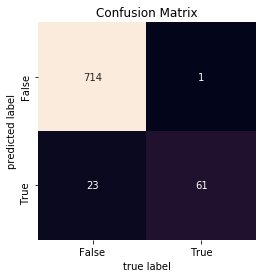

In [75]:
lucem_illud.plotConfusionMatrix(naiveBayes, train_data_df)

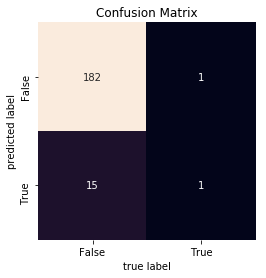

In [76]:
lucem_illud.plotConfusionMatrix(naiveBayes, test_data_df)

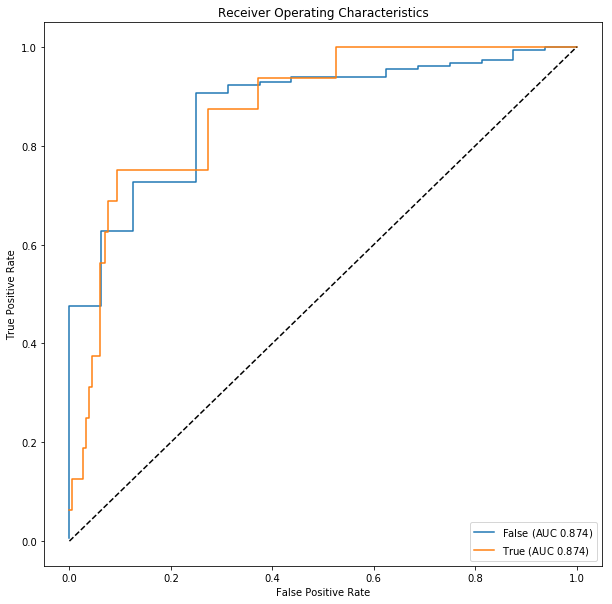

In [77]:
lucem_illud.plotMultiROC(naiveBayes, test_data_df)

Both of these classifiers are quite good, with the NB model being better. Makes sense considering the spread of the data.

In [28]:
newchatsamples = ldpdf.chat_tokens.apply(lambda x: ' '.join(wordsample100(x)))
newbooksamples = bookdf.tokens.apply(lambda x: ' '.join(wordsample100(x)))

In [47]:
for booksamp in newbooksamples:
    predict_category(booksamp, naiveBayes, TFVectorizer)

# Decision Trees

Decision trees can be used to predict both categorical/class labels (i.e., classification) and continuous labels (i.e., regression).

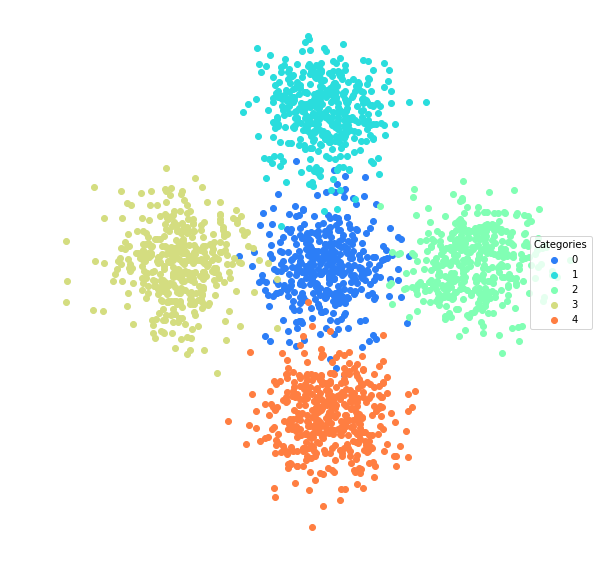

In [52]:
blobs_df = lucem_illud.multiBlobs(noise=.2, centers=[(0,0), (0,5), (5,0), (-5,0), (0,-5)])
df_exampleTree_train, df_exampleTree_test = lucem_illud.trainTestSplit(blobs_df)
lucem_illud.plotter(df_exampleTree_train)

Now we import our Decision Tree classifier from sklearn.tree (familiar syntax) and fit it using the fit method.

In [53]:
clf_tree = sklearn.tree.DecisionTreeClassifier(max_depth=4,random_state=0)
clf_tree.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

To see what's going on visually with the classification: 

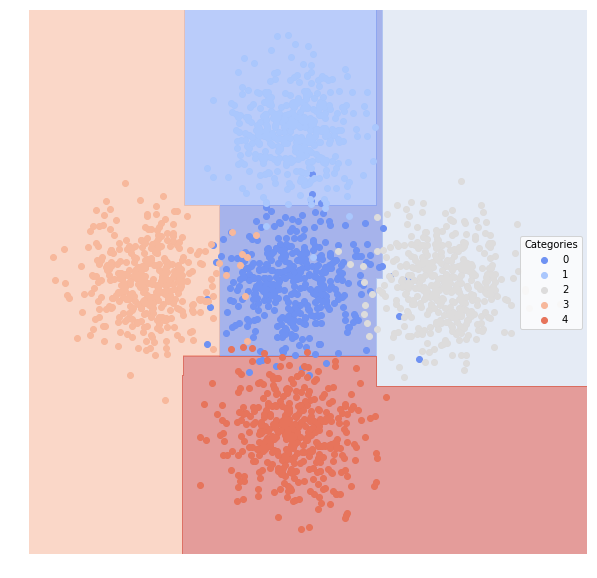

In [595]:
lucem_illud.plotregions(clf_tree, df_exampleTree_train)

In [596]:
lucem_illud.evaluateClassifier(clf_tree, df_exampleTree_test)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.970235,0.922475,0.018,0.960000,0.950495
1,0.996134,0.973913,0.006,0.973913,1.000000
2,0.980729,0.957956,0.008,0.987654,0.963855
3,0.989627,0.976811,0.006,0.990826,0.981818
4,0.998768,0.989474,0.002,0.989474,1.000000


Lets look at accuracy:

In [597]:
sklearn.metrics.accuracy_score(df_exampleTree_test['category'],clf_tree.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))

0.98

What happens if we trim the tree?

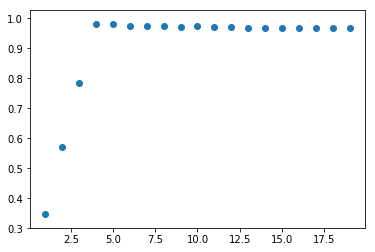

In [598]:
depthvec = []
scorevec = []
for i in range(1,20):
    tree2 = sklearn.tree.DecisionTreeClassifier(max_depth=i,random_state=0)
    tree2.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category'])
    score = sklearn.metrics.accuracy_score(df_exampleTree_test['category'], tree2.predict(np.stack(df_exampleTree_test['vect'], axis = 0)))
    depthvec.append(i)
    scorevec.append(score)
plt.scatter(depthvec,scorevec)
plt.show()

We can select different layers of the decision tree or "prune" it. At approximately four layers down in the decision tree, the shape is somewhat odd, suggesting that our model is overfitting beyond those four layers.

Combining multiple overfitting estimators turns out to be a key idea in machine learning. This is called **bagging** and is a type of **ensemble** method. The idea is to make many randomized estimators--each can overfit, as decision trees are wont to do--but then to combine them, ultimately producing a better classification. A **random forest** is produced by bagging decision trees.

In [599]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [600]:
bag.fit(np.stack(df_exampleTree_train['vect'], axis =0), df_exampleTree_train['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

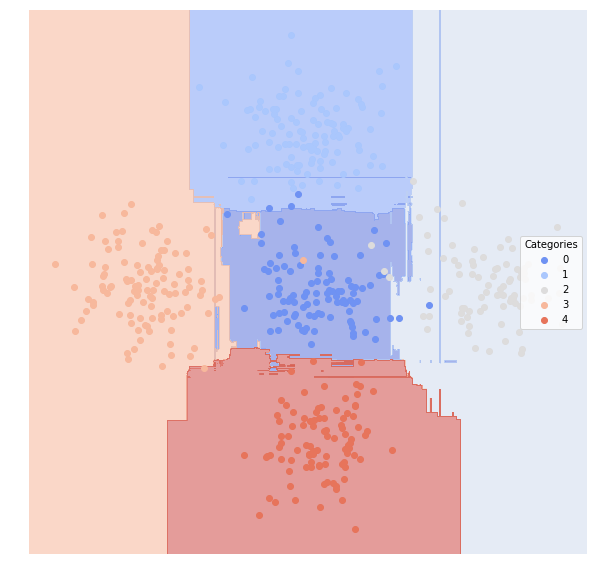

In [601]:
lucem_illud.plotregions(bag, df_exampleTree_test)

In [602]:
lucem_illud.evaluateClassifier(bag, df_exampleTree_test)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
0,0.967729,0.904584,0.022,0.941176,0.950495
1,0.996134,0.973913,0.006,0.973913,1.000000
2,0.979530,0.946347,0.010,0.975610,0.963855
3,0.986364,0.978727,0.006,1.000000,0.972727
4,0.993449,0.980837,0.004,0.989362,0.989362


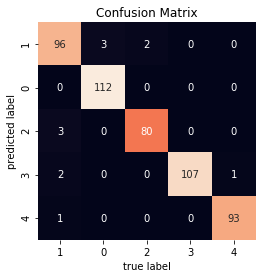

In [603]:
lucem_illud.plotConfusionMatrix(bag, df_exampleTree_test)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">In the cells immediately following, perform decision tree and random forest classification (binary, multinomial or continuous) using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. As with ***Exercise 2***, these could be crowd-sourced codes gathered through Amazon Mechanical Turk last week. Visualize the classification of data points. Calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Now build an ensemble classifier by bagging trees into a random forest. Visualize the result. How do these classifiers perform? What does ensemble learning do?

In [86]:
clf_tree.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

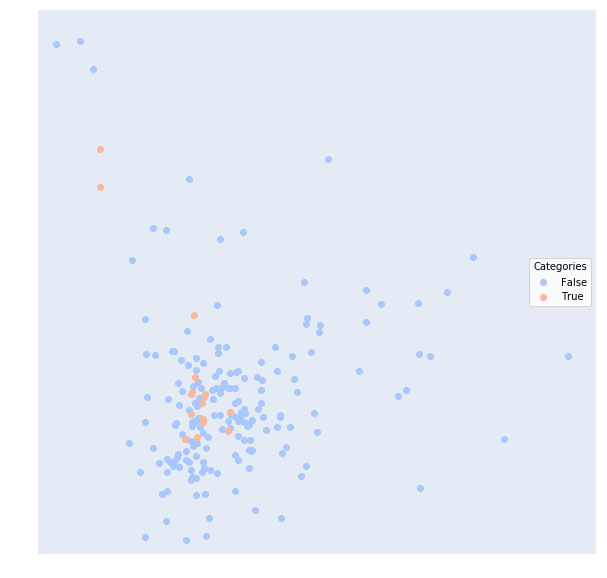

In [91]:
lucem_illud.plotregions(clf_tree, test_data_df)

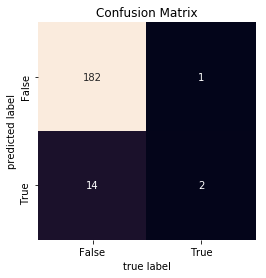

In [90]:
lucem_illud.plotConfusionMatrix(clf_tree, test_data_df)

In [92]:
lucem_illud.evaluateClassifier(clf_tree, test_data_df)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
False,0.559768,0.928522,0.075377,0.928571,0.994536
True,0.559768,0.153685,0.075377,0.666667,0.125000


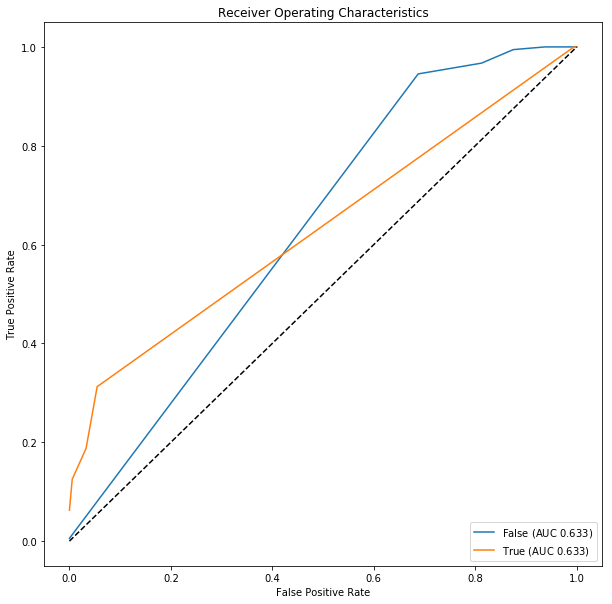

In [93]:
lucem_illud.plotMultiROC(clf_tree, test_data_df)

Looks horrendous! It seems to classify practically everything as chat.

What about bagging?

In [94]:
tree = sklearn.tree.DecisionTreeClassifier(max_depth=10) #Create an instance of our decision tree classifier.

bag = sklearn.ensemble.BaggingClassifier(tree, n_estimators=100, max_samples=0.8, random_state=1) #Each tree uses up to 80% of the data

In [95]:
bag.fit(np.stack(train_data_df['vect'], axis =0), train_data_df['category']) #Fit the bagged classifier

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=100, n_jobs=1, oob_score=False,
         random_state=1, verbose=0, warm_start=False)

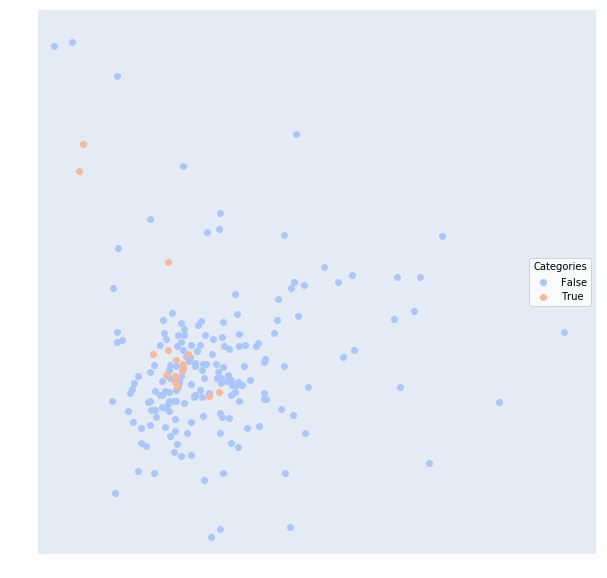

In [96]:
lucem_illud.plotregions(bag, test_data_df)

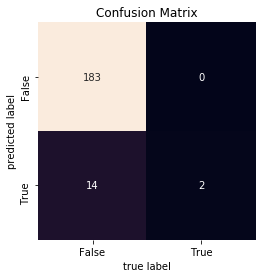

In [97]:
lucem_illud.plotConfusionMatrix(bag, test_data_df)

In [98]:
lucem_illud.evaluateClassifier(bag, test_data_df)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
False,0.5625,0.928934,0.070352,0.928934,1.000
True,0.5625,0.195352,0.070352,1.000000,0.125


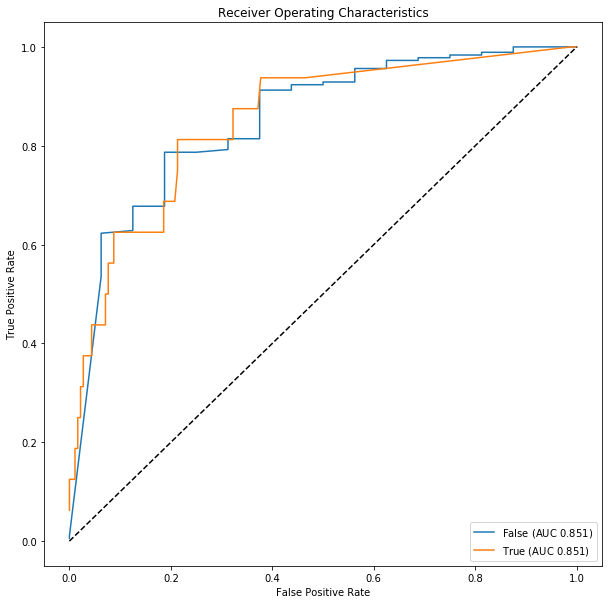

In [99]:
lucem_illud.plotMultiROC(bag, test_data_df)

While the AUC is better, in general this classifier doesn't perform much better than the simpler Decision Tree. Again, it errs on the side of false negatives – it classifies nearly everything as not a book. This must have something to do with how my data are organized.

# K-Nearest Neighbors

The K-Nearest neighbors classifier takes a simpler premise than those before: Find the closest labeled datapoint in set and "borrow" its label.

Let's use newsgroup data again.

In [107]:
newsgroupsDF[:5]

,category,source_file,text,tokenized_text,normalized_text
0,talk.religion.misc,/Users/Reid/scikit_learn_data/20news_home/20ne...,\n\nParadise and salvation are not the same th...,"[Paradise, and, salvation, are, not, the, same...","[paradis, salvat, thing, salvat, better, refer..."
1,talk.religion.misc,/Users/Reid/scikit_learn_data/20news_home/20ne...,\nYou're admitting a lot more than that. You ...,"[You, 're, admitting, a, lot, more, than, that...","[admit, lot, admit, moral, situat, admit, acti..."
2,talk.religion.misc,/Users/Reid/scikit_learn_data/20news_home/20ne...,"\n\nJesus also recognized other holy days, lik...","[Jesus, also, recognized, other, holy, days, ,...","[jesus, also, recogn, holi, day, like, passov,..."
3,talk.religion.misc,/Users/Reid/scikit_learn_data/20news_home/20ne...,In <lsjc8cINNmc1@saltillo.cs.utexas.edu> turpi...,"[In, <, lsjc8cINNmc1, @, saltillo.cs.utexas.ed...","[turpin, russel, turpin, regard, love, less, b..."
4,talk.religion.misc,/Users/Reid/scikit_learn_data/20news_home/20ne...,"\nI'm sorry, but He does not! Ever read the F...","[I, 'm, sorry, ,, but, He, does, not, !, Ever,...","[sorri, doe, ever, read, first, command]"


Make a testing and training set:

In [108]:
holdBackFraction = .2
train_ng_df, test_ng_df = lucem_illud.trainTestSplit(newsgroupsDF, holdBackFraction=holdBackFraction)

Let's initialize our k-nearest neighbors classifier:

In [109]:
n_neighbors = 15
weights="uniform"
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

Let's try to classify using the TF-IDF vectors:

In [110]:
TFVectorizer_ng = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
TFVects_ng = TFVectorizer_ng.fit_transform(train_ng_df['text'])
train_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_ng.todense()]

In [111]:
clf_knearest.fit(np.stack(train_ng_df['vect'], axis = 0), train_ng_df['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [112]:
lucem_illud.evaluateClassifier(clf_knearest, train_ng_df)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
sci.space,0.565515,0.318307,0.327916,0.396947,0.322314
soc.religion.christian,0.504124,0.287412,0.279164,1.000000,0.008247
comp.graphics,0.621413,0.349581,0.262333,0.495627,0.378619
talk.religion.misc,0.567711,0.200599,0.506094,0.211597,0.681967


And lets look at the testing data

In [113]:
#Create vectors
TFVects_test = TFVectorizer_ng.transform(test_ng_df['text'])
test_ng_df['vect'] = [np.array(v).flatten() for v in TFVects_test.todense()]

#Add to df
test_ng_df['nb_predict'] = clf_knearest.predict(np.stack(test_ng_df['vect'], axis=0))

#Test
print("Testing score:")
print(clf_knearest.score(np.stack(test_ng_df['vect'], axis=0), test_ng_df['category']))

Testing score:
0.20930232558139536


Let's produce another confusion matrix:

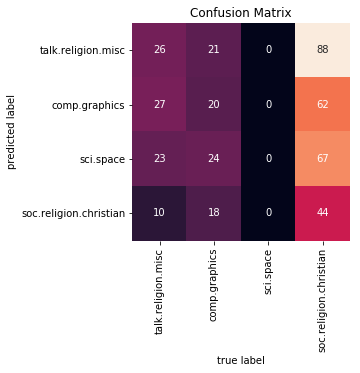

In [114]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_ng_df)

You can produce the PCA space visual if you want, altough it can take a very long time, so we'll leave it optionally commented out:

In [ ]:
#lucem_illud.plotregions(clf_knearest, test_ng_df)

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">In the cells immediately following, perform and visualize k-nearest neighbor classification using training, testing and extrapolation (uncoded) data from texts and hand-classifications associated with your final project. Visualize the classification of data points and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). Articulate how the *k*-nearest neighbor approach relates to *k*-means clustering explored in ***week 3***?

I'll first try with 15 neighbors, like above.

In [115]:
clf_knearest = sklearn.neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

In [116]:
clf_knearest.fit(np.stack(train_data_df['vect'], axis = 0), train_data_df['category'])

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=15, p=2,
           weights='uniform')

In [117]:
lucem_illud.evaluateClassifier(clf_knearest, train_data_df)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
False,0.577381,0.909669,0.088861,0.909669,1.000000
True,0.577381,0.243623,0.088861,1.000000,0.154762


In [118]:
lucem_illud.evaluateClassifier(clf_knearest, test_data_df)

/Users/josephdenby/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
False,0.5,0.919598,0.080402,0.919598,1.0
True,0.5,0.080402,0.080402,0.000000,0.0


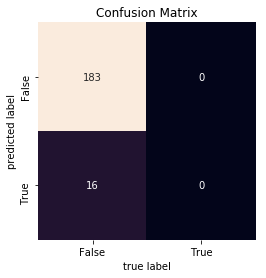

In [119]:
lucem_illud.plotConfusionMatrix(clf_knearest, test_data_df)

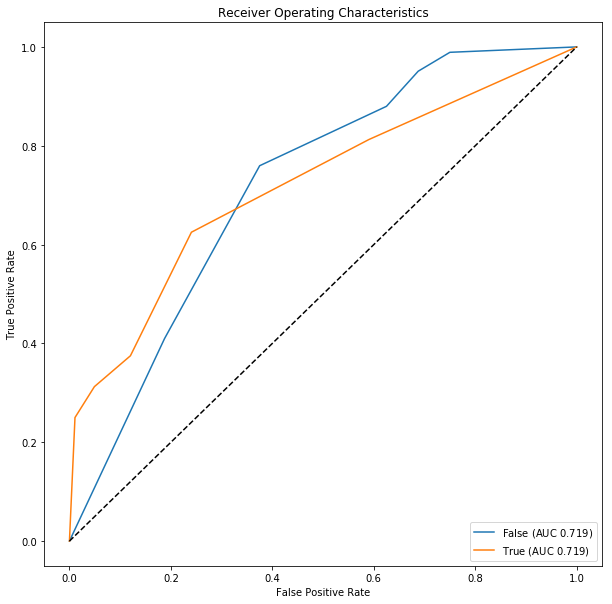

In [120]:
lucem_illud.plotMultiROC(clf_knearest, test_data_df)

Yikes still pretty bad.

# SVMs

Now we will examine Support Vector Machines, an approach that creates the partition that preserves the "maximum margin" between classes.

We will use a few sub forums from reddit--which tend to share text rather than memes--namely `talesfromtechsupport`, `badroommates`, `weeabootales` and `relationships`. The top 100 text posts from each have been saved to `data/reddit.csv`.

In [121]:
redditDf = pandas.read_csv('../data/reddit.csv', index_col = 0)

#Drop a couple missing values

redditDf = redditDf.dropna()

#Set category

redditDf['category'] = redditDf['subreddit']

#tokenize and normalize
redditDf['tokenized_text'] = redditDf['text'].apply(lambda x: nltk.word_tokenize(x))
redditDf['normalized_text'] = redditDf['tokenized_text'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = lucem_illud.stemmer_basic))

We will tf.idf the data to make our vectors:

In [122]:
redditTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, min_df=3, stop_words='english', norm='l2')
redditTFVects = redditTFVectorizer.fit_transform([' '.join(l) for l in redditDf['normalized_text']])
redditDf['vect'] = [np.array(v).flatten() for v in redditTFVects.todense()]

Initilize the model and make a train test split:

In [123]:
holdBackFraction = .2
train_redditDf, test_redditDf = lucem_illud.trainTestSplit(redditDf, holdBackFraction=holdBackFraction)

In [124]:
clf_svm = sklearn.svm.SVC(kernel='linear', probability = False)
#probability = True is slower but  lets you call predict_proba()
clf_svm.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

...and consider the results:

In [125]:
lucem_illud.evaluateClassifier(clf_svm, test_redditDf)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Weeaboo Tales: stories about the extreme fans of japanese culture,0.993506,0.990148,0.003135,1.000000,0.987013
Bad Roommates: Tales of Irritation,0.969754,0.907067,0.025078,0.935065,0.960000
Tales From Tech Support,0.974359,0.961257,0.012539,1.000000,0.948718
Relationships,0.970103,0.912677,0.028213,0.934783,0.966292


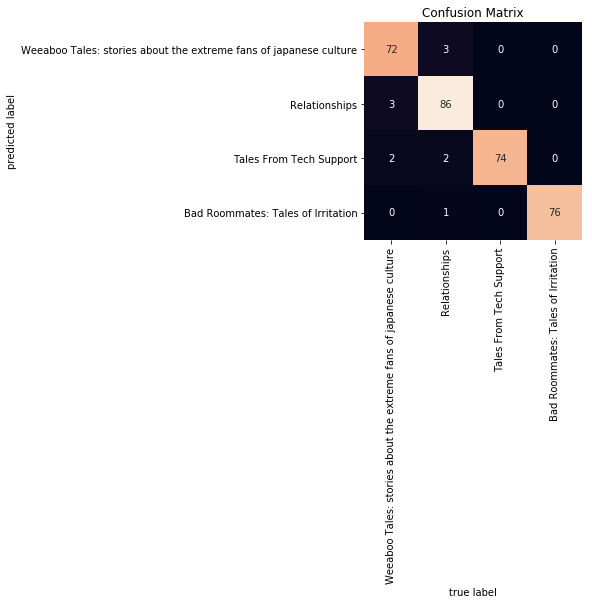

In [126]:
lucem_illud.plotConfusionMatrix(clf_svm, test_redditDf)

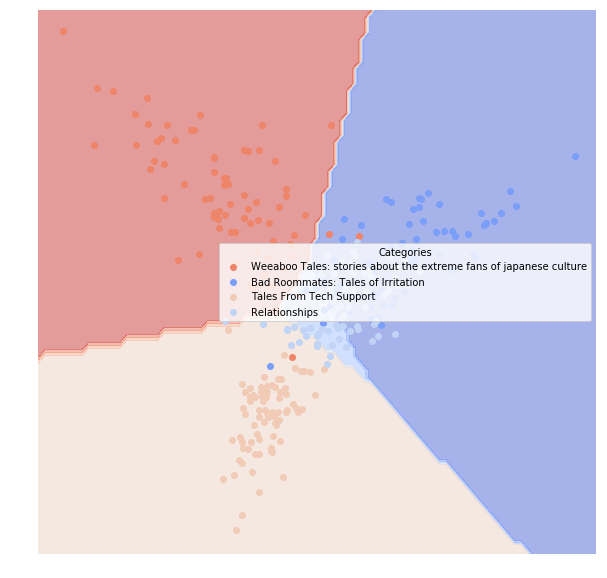

In [127]:
lucem_illud.plotregions(clf_svm, test_redditDf)

# Neural Nets

We include an example of a simple neural network, the Multi-layer Perceptron (MLP) that learns a function $f(\cdot): R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. Given a set of features $X = {x_1, x_2, ..., x_m}$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers. The following figure shows a one hidden layer MLP with scalar output. ![title](../data/multilayerperceptron_network.png) The leftmost layer, known as the input layer, consists of a set of "neurons" $\{x_i | x_1, x_2, ..., x_m\}$ representing the input features (e.g., weighted words). Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1x_1 + w_2x_2 + ... + w_mx_m$, followed by a non-linear activation function $g(\cdot):R \rightarrow R$ - like the logistic or hyperbolic tan function. The output layer receives the values from the last hidden layer and transforms them into output values.

In [128]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_redditDf['vect'], axis=0), train_redditDf['category'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [129]:
lucem_illud.evaluateClassifier(clf_nn, test_redditDf)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
Weeaboo Tales: stories about the extreme fans of japanese culture,0.991440,0.977329,0.006270,0.987013,0.987013
Bad Roommates: Tales of Irritation,0.965137,0.908717,0.025078,0.946667,0.946667
Tales From Tech Support,0.980769,0.970943,0.009404,1.000000,0.961538
Relationships,0.970103,0.912677,0.028213,0.934783,0.966292


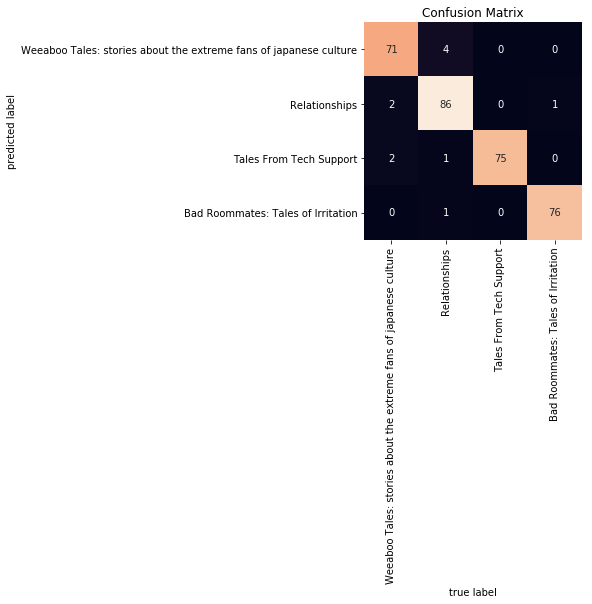

In [130]:
lucem_illud.plotConfusionMatrix(clf_nn, test_redditDf)

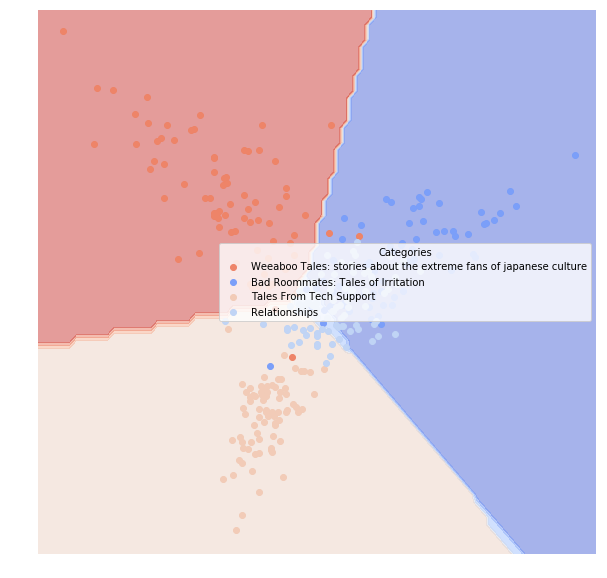

In [131]:
lucem_illud.plotregions(clf_nn, test_redditDf)

It performs very well.

## <span style="color:red">*Exercise 5*</span>

<span style="color:red">In the cells immediately following, perform a neural network classification and calculate relevant metrics (e.g., precision, recall, the F-measure, and AUC). How does this classify relevant to *k*-nearest neighbor, Naive Bayes, logistic and decision-tree approaches?

In [132]:
clf_nn = sklearn.neural_network.MLPClassifier()
clf_nn.fit(np.stack(train_data_df['vect'], axis=0), train_data_df['category'])

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [133]:
lucem_illud.evaluateClassifier(clf_nn, test_data_df)

,AUC,Average_Precision,Error_Rate,Precision,Recall
Category,,,,,
False,0.679303,0.946913,0.065327,0.947368,0.983607
True,0.679303,0.300251,0.065327,0.666667,0.375000


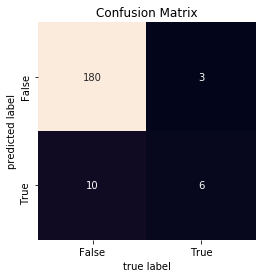

In [134]:
lucem_illud.plotConfusionMatrix(clf_nn, test_data_df)

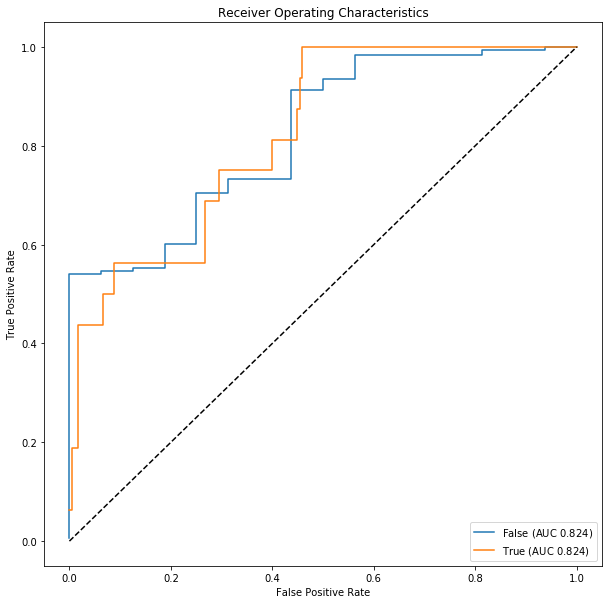

In [136]:
lucem_illud.plotMultiROC(clf_nn, test_data_df)

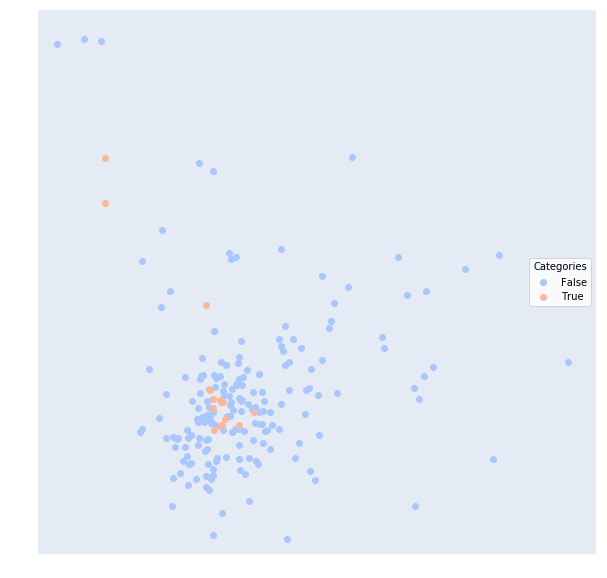

In [135]:
lucem_illud.plotregions(clf_nn, test_data_df)

This neural net still doesn't perform particularly well, especially when compared to the earlier classifiers. It also tends to err on the side of false negatives – it correctly captures most of the chat excerpts, but very few of the book excerpts.